Test Set Average Interval Width: 0.784
Test Set Standard Deviation of Predictions: 0.024
Test Set Coverage Probability: 0.000
Test Set Entropy: 0.521


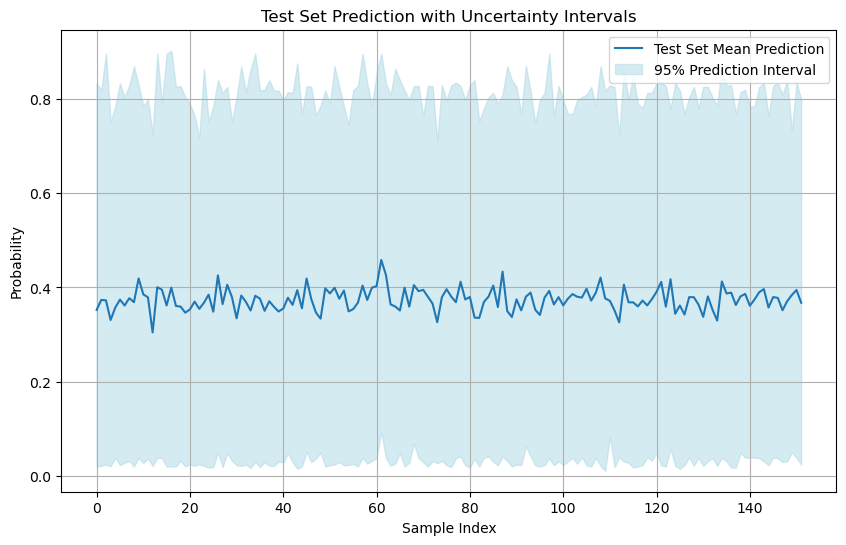

Validation Set Average Interval Width: 0.508
Validation Set Standard Deviation of Predictions: 0.014
Validation Set Coverage Probability: 0.000
Validation Set Entropy: 0.632


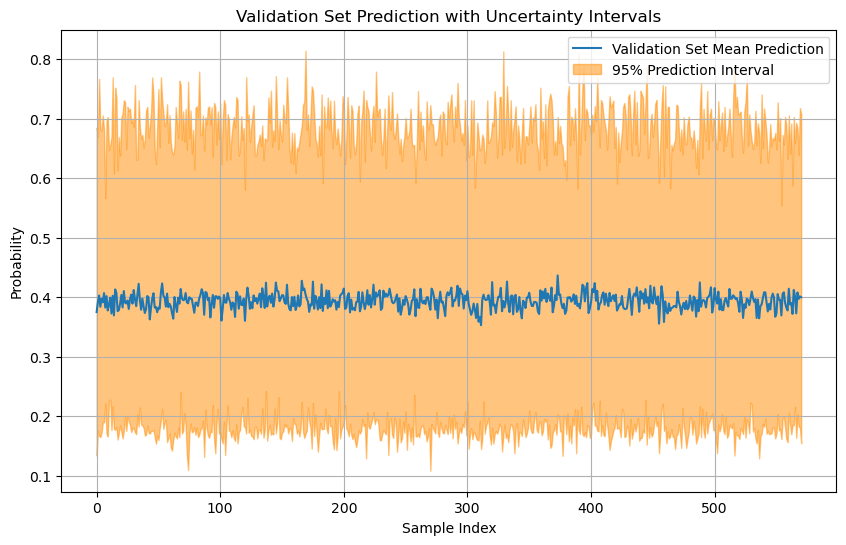

In [2]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import PandasTools, DataStructs, rdFingerprintGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, log_loss
import joblib
from sklearn.utils import resample

# Load SDF file and convert to DataFrame
sdf_file = "Structures_759_training.sdf"
df = PandasTools.LoadSDF(sdf_file, smilesName='SMILES', molColName='Molecule', includeFingerprints=False)

# List of selected descriptors
selected_columns = [
    'r_qp_mol_MW', 'r_qp_volume', 'r_qp_SASA', 'r_qp_PSA',
    'r_qp_QPlogS', 'r_qp_CIQPlogS', 'r_qp_QPlogPoct', 'r_qp_QPlogPo/w',
    'r_qp_dipole', 'r_qp_donorHB', 'r_qp_accptHB',
    'r_qp_QPPCaco', 'r_qp_QPlogBB', 'i_qp_HumanOralAbsorption',
    'r_qp_PercentHumanOralAbsorption', 'r_qp_QPlogHERG',
    'r_qp_IP(eV)', 'r_qp_EA(eV)',
    'i_qp_#stars', 'i_qp_#rotor', 'i_qp_RuleOfFive', 'i_qp_RuleOfThree', 'i_qp_#NandO'
]

# Calculate molecular fingerprints
morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=6, fpSize=2048)
def calculate_fcfp6(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fcfp6 = morgan_gen.GetFingerprint(mol)
    array = np.zeros((2048,), dtype=int)
    DataStructs.ConvertToNumpyArray(fcfp6, array)
    return array

# Generate Morgan fingerprints and convert to DataFrame
fcfp6_data = df['SMILES'].apply(calculate_fcfp6)
fcfp6_df = pd.DataFrame(fcfp6_data.tolist(), index=df.index)

# Standardize and PCA on descriptors
features = df[selected_columns].fillna(0)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
pca = PCA(n_components=9)
principal_components = pca.fit_transform(scaled_features)

# Combine PCA descriptors with fingerprints
combined_features = pd.DataFrame(np.hstack((principal_components, fcfp6_df.values)), index=df.index)

# Load the best pre-trained Random Forest model
best_rf_model = joblib.load('best_random_forest_model.pkl')

# Extract target variable
target_column = 'Stable'
labels = df[target_column].astype(int)

# Split train/test data
X_train, X_test, y_train, y_test = train_test_split(
    combined_features, labels, test_size=0.2, random_state=42
)

# Function to simulate predictions with uncertainty
def simulate_with_uncertainty(model, X, n_iterations=100, percentile=95):
    simulations = []
    for _ in range(n_iterations):
        X_resampled = resample(X)
        sim_pred_probs = model.predict_proba(X_resampled)[:, 1]
        simulations.append(sim_pred_probs)
    
    simulations = np.array(simulations)
    mean_prediction = np.mean(simulations, axis=0)
    lower_bound = np.percentile(simulations, (100 - percentile) / 2.0, axis=0)
    upper_bound = np.percentile(simulations, 100 - (100 - percentile) / 2.0, axis=0)
    
    return mean_prediction, lower_bound, upper_bound

# Calculate uncertainty using the simulation function for Test Set
mean_pred_calib, lower_calib, upper_calib = simulate_with_uncertainty(best_rf_model, X_test)

# Quantitative metrics on uncertainty
interval_widths = upper_calib - lower_calib
average_interval_width = np.mean(interval_widths)
print(f"Test Set Average Interval Width: {average_interval_width:.3f}")

std_dev = np.std(mean_pred_calib)
print(f"Test Set Standard Deviation of Predictions: {std_dev:.3f}")

coverage_prob = np.mean((y_test >= lower_calib) & (y_test <= upper_calib))
print(f"Test Set Coverage Probability: {coverage_prob:.3f}")

y_prob_calibrated = best_rf_model.predict_proba(X_test)[:, 1]
epsilon = 1e-9  # Small value to prevent log(0)
entropy = -np.mean(y_prob_calibrated * np.log(y_prob_calibrated + epsilon) + (1 - y_prob_calibrated) * np.log(1 - y_prob_calibrated + epsilon))
print(f"Test Set Entropy: {entropy:.3f}")

# Plotting the uncertainty intervals for Test Set
plt.figure(figsize=(10, 6))
plt.plot(mean_pred_calib, label='Test Set Mean Prediction')
plt.fill_between(range(len(mean_pred_calib)), lower_calib, upper_calib, color='lightblue', alpha=0.5, label='95% Prediction Interval')
plt.title('Test Set Prediction with Uncertainty Intervals')
plt.xlabel('Sample Index')
plt.ylabel('Probability')
plt.legend()
plt.grid(True)
plt.show()

# Validation dataset
sdf_file_unseen = "Structures_test_571.sdf"
df_validation = PandasTools.LoadSDF(sdf_file_unseen, smilesName='SMILES', molColName='Molecule', includeFingerprints=False)

# Prepare validation features
features_validation = df_validation[selected_columns].fillna(0)
scaled_features_validation = scaler.transform(features_validation)
principal_components_validation = pca.transform(scaled_features_validation)

fcfp6_validation_data = df_validation['SMILES'].apply(calculate_fcfp6)
fcfp6_validation_df = pd.DataFrame(fcfp6_validation_data.tolist(), index=df_validation.index)

combined_features_validation = np.hstack((principal_components_validation, fcfp6_validation_df.values))

# Extract validation labels
labels_validation = df_validation[target_column].astype(int)

# Calculate uncertainty using the simulation function for Validation Set
mean_pred_calib_val, lower_calib_val, upper_calib_val = simulate_with_uncertainty(best_rf_model, combined_features_validation)

# Quantitative metrics on uncertainty for Validation Set
interval_widths_val = upper_calib_val - lower_calib_val
average_interval_width_val = np.mean(interval_widths_val)
print(f"Validation Set Average Interval Width: {average_interval_width_val:.3f}")

std_dev_val = np.std(mean_pred_calib_val)
print(f"Validation Set Standard Deviation of Predictions: {std_dev_val:.3f}")

coverage_prob_val = np.mean((labels_validation >= lower_calib_val) & (labels_validation <= upper_calib_val))
print(f"Validation Set Coverage Probability: {coverage_prob_val:.3f}")

y_prob_calibrated_val = best_rf_model.predict_proba(combined_features_validation)[:, 1]
entropy_val = -np.mean(y_prob_calibrated_val * np.log(y_prob_calibrated_val + epsilon) + (1 - y_prob_calibrated_val) * np.log(1 - y_prob_calibrated_val + epsilon))
print(f"Validation Set Entropy: {entropy_val:.3f}")

# Plotting the uncertainty intervals for Validation Set
plt.figure(figsize=(10, 6))
plt.plot(mean_pred_calib_val, label='Validation Set Mean Prediction')
plt.fill_between(range(len(mean_pred_calib_val)), lower_calib_val, upper_calib_val, color='darkorange', alpha=0.5, label='95% Prediction Interval')
plt.title('Validation Set Prediction with Uncertainty Intervals')
plt.xlabel('Sample Index')
plt.ylabel('Probability')
plt.legend()
plt.grid(True)
plt.show()